In [190]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [193]:
df = pd.read_csv('BTC-USD (1).csv')
df.dropna(inplace=True)

In [194]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-12,266.145996,272.203003,265.200012,267.795990,267.795990,18880300.0
1,2015-01-13,267.394012,268.277008,219.906006,225.860992,225.860992,72843904.0
2,2015-01-14,223.893997,223.893997,171.509995,178.102997,178.102997,97638704.0
3,2015-01-15,176.897003,229.067001,176.897003,209.843994,209.843994,81773504.0
4,2015-01-16,209.070007,221.591003,199.770996,208.097000,208.097000,38421000.0


In [195]:
train_dates = pd.to_datetime(df['Date'])

In [196]:
#Variables for training
cols = list(df)[1:6]
cols

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [197]:
df_for_training = df[cols].astype(float)

In [198]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


In [199]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).
trainX = []
trainY = []

In [200]:
n_future = 3   # Number of days we want to predict into the future
n_past = 180    # Number of past days we want to use to predict the future

In [201]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [202]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (2097, 180, 5).
trainY shape == (2097, 1).


In [203]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))


In [204]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 180, 64)           17920     
_________________________________________________________________
lstm_24 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [205]:
history = model.fit(trainX, trainY, epochs=50, batch_size=100, validation_split=0.1, verbose=1)

Epoch 1/50
19/19 [==============================] - 13s 414ms/step - loss: 0.0040 - val_loss: 0.0136
Epoch 2/50
19/19 [==============================] - 5s 275ms/step - loss: 6.8227e-04 - val_loss: 0.0639
Epoch 3/50
19/19 [==============================] - 5s 281ms/step - loss: 4.7286e-04 - val_loss: 0.0077
Epoch 4/50
19/19 [==============================] - 5s 271ms/step - loss: 3.8818e-04 - val_loss: 0.0075
Epoch 5/50
13/19 [===================>..........] - ETA: 1s - loss: 3.2947e-04

KeyboardInterrupt: 

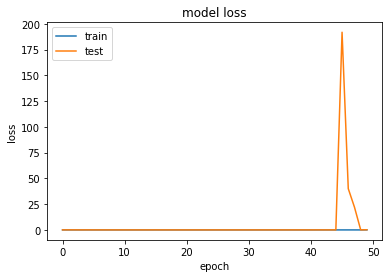

In [187]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [169]:
#Forecasting...
#Start with the last day in training date and predict future...
n_future=90  #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

C:\Users\Dell\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


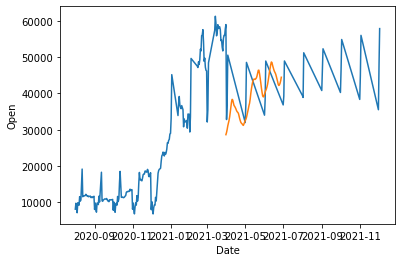

In [170]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-8-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])


In [171]:
dfplt=df_forecast

In [172]:
dfplt.set_index('Date')

,Open
Date,
2021-03-31,28651.568359
2021-04-01,29270.171875
2021-04-02,30083.103516
2021-04-03,31085.291016
2021-04-04,31831.781250
...,...
2021-06-24,42179.136719
2021-06-25,42370.191406
2021-06-26,42796.355469


In [206]:
forecast

array([[0.42066166],
       [0.43166518],
       [0.4461254 ],
       [0.46395203],
       [0.4772304 ],
       [0.49021918],
       [0.50783324],
       [0.5312239 ],
       [0.5568392 ],
       [0.5801102 ],
       [0.5933553 ],
       [0.58981025],
       [0.57645714],
       [0.563658  ],
       [0.5592271 ],
       [0.55380654],
       [0.5471529 ],
       [0.53885263],
       [0.5331274 ],
       [0.5298823 ],
       [0.5253488 ],
       [0.5134611 ],
       [0.5003556 ],
       [0.48954716],
       [0.48074117],
       [0.47628132],
       [0.47339392],
       [0.46903816],
       [0.4659762 ],
       [0.47332472],
       [0.48233816],
       [0.48967898],
       [0.49601296],
       [0.5048901 ],
       [0.5184165 ],
       [0.53300154],
       [0.5470305 ],
       [0.56260765],
       [0.574659  ],
       [0.595075  ],
       [0.62287354],
       [0.6445795 ],
       [0.6636956 ],
       [0.6791632 ],
       [0.6871824 ],
       [0.69243276],
       [0.6922245 ],
       [0.691